In [1]:
import pandas as pd
import numpy as np

## Load in sample data
1.   Load in data file one-by-one and store them as list of pd.DataFrame. 
2.   Merge them into one data frame
3.   Extract necessary columns
4.   Concatenate `title` with `content`

In [2]:
import zipfile
import json

In [3]:
data_df = []

with zipfile.ZipFile('MetabaseSamples.zip', 'r') as z:
    for filename in z.namelist():
        # make it compatible to MacOS system
        if not str(filename).startswith('__MACOSX/'):
            with z.open(filename) as file:
                json_file = json.load(file)
                df = pd.DataFrame(json_file)
                data_df.append(df)
                
data_df = pd.concat(data_df, ignore_index=True)
data_df['country'] = data_df.source.map(lambda x: x['location']['country'])  
data_df['publisher'] = data_df.source.map(lambda x: x['name'])

# concatenate the title to the content by a new line char
data_df['content'] = data_df.title + '\n' + data_df.content
data_df = data_df[['content', 'country', 'publisher']]
data_df

,content,country,publisher
0,Anatara Lifesciences Ltd (ASX:ANR) Human Healt...,Australia,ABN Newswire
1,Cyprium Metals Ltd (ASX:CYM) Diamond Drilling ...,Australia,ABN Newswire
2,Ellis Martin Report: Skyharbour Resources (CVE...,Australia,ABN Newswire
3,Betmakers Technology Group Ltd (ASX:BET) Sport...,Australia,ABN Newswire
4,NOVONIX Ltd (ASX:NVX) Benchmark Week 2020 Pres...,Australia,ABN Newswire
...,...,...,...
135,Towards a gender-equal world: a mission for al...,South Africa,Mail & Guardian
136,Cryptic crossword 261 - 4 December\nThe post C...,South Africa,Mail & Guardian
137,Yet another treaty aims to protect African wom...,South Africa,Mail & Guardian
138,Pivot your small business to online\nThis Mail...,South Africa,Mail & Guardian


Let's have a quick view of the countries included in this dataset.

In [4]:
data_df.country.unique()

array(['Australia', 'Sri Lanka', 'Canada', 'Malaysia', 'India',
       'Pakistan', 'South Africa'], dtype=object)

## Clean up dataset
### Define some constants and helper functions

In [5]:
import re
import requests
import spacy

# Download the small package
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [6]:
CONVERT_DICT_URL = "https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_dict = requests.get(CONVERT_DICT_URL).json()

def americanize(string):
    '''
    Convert all British English spelling to American spelling in the input string
    source: https://stackoverflow.com/questions/42329766/python-nlp-british-english-vs-american-english
    -- Modified the code from source to meet our special requirement here. 
    Input:
      sentence: a text string
    Return: 
      string: a string with all words in English spelling
    '''
    for british_spelling, american_spelling in british_to_american_dict.items():
        string = re.sub(r'\b'+british_spelling+'\b', american_spelling, string, flags=re.IGNORECASE)
  
    return string

In [7]:
REMOVED_ENTITY_TYPE = ('PERSON', 'GPE', 'ORG')
SENT_TO_REMOVE = 'For any query with respect to this article or any other content requirement, please contact Editor at'
spacy_nlp = spacy.load('en_core_web_sm')

def preprocess(sentence):
    '''
    Preprocessing the raw text and prepare for model input
    Input:
      sentence: a text string
    Return:
      sentence: A preprocessed sentence for BERT encoder
    '''
    # Step 1: URL and Email Removal
    # Remove the repeating phrase
    sentence = re.sub(SENT_TO_REMOVE, ' ', sentence)
    # Remove website url and email address
    sentence = re.sub(r'(http\S+)|(\S*@\S*\s?)', '', sentence, flags=re.MULTILINE)
    
    # Step 2: Convert British to American English
    sentence = americanize(sentence)
      
    # Step 3: Identify and Remove Named Entity
    # Use spacy to get a sequence of tokens for named entity removal
    sentence = spacy_nlp(sentence)
    # Remove named entities
    sentence = ' '.join([str(ent) for ent in sentence if ent.ent_type_ not in REMOVED_ENTITY_TYPE])
    
    # Step 4: Cleanup
    # Remove new line character
    sentence = re.sub('\n', ' ', sentence)   
    # Remove single letter word since it doesn't make sense; might be some technical terms that are trimmed off
    sentence = re.sub('\ [a-zA-z]\ ', ' ', sentence, flags=re.IGNORECASE)
    # Remove redundant spaces and unnecessary spaces between punctuations and letters
    sentence = re.sub(' +', ' ', sentence)
    sentence  = re.sub(r'(\s([,.?!%"\']))|(?<=\[|\()(.*?)(?=\)|\])', lambda x: x.group().strip(), sentence)
    
    return sentence

In [8]:
data_df['content_cleaned'] = data_df.content.map(preprocess)
data_df

,content,country,publisher,content_cleaned
0,Anatara Lifesciences Ltd (ASX:ANR) Human Healt...,Australia,ABN Newswire,(ASX : ANR) Human Health Update Anatara Lifesc...
1,Cyprium Metals Ltd (ASX:CYM) Diamond Drilling ...,Australia,ABN Newswire,(ASX : CYM) Diamond Drilling Commenced at Nana...
2,Ellis Martin Report: Skyharbour Resources (CVE...,Australia,ABN Newswire,Report : (: SYH) Expands High Grade Maverick E...
3,Betmakers Technology Group Ltd (ASX:BET) Sport...,Australia,ABN Newswire,(ASX : BET) Limited (ASX : BET) (FRA : T07) no...
4,NOVONIX Ltd (ASX:NVX) Benchmark Week 2020 Pres...,Australia,ABN Newswire,(ASX :) Benchmark Week 2020 Presentation (ASX ...
...,...,...,...,...
135,Towards a gender-equal world: a mission for al...,South Africa,Mail & Guardian,Towards gender - equal world : mission for all...
136,Cryptic crossword 261 - 4 December\nThe post C...,South Africa,Mail & Guardian,Cryptic crossword 261 - 4 December The post Cr...
137,Yet another treaty aims to protect African wom...,South Africa,Mail & Guardian,Yet another treaty aims to protect African wom...
138,Pivot your small business to online\nThis Mail...,South Africa,Mail & Guardian,Pivot your small business to online This Mail ...


## View BERT's built-in preprocessor tokenizing result

In [9]:
! pip install transformers
from transformers import AutoTokenizer

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer.tokenize('BERT Encoder is a POWERFUL encoder that produces word embeddings!'))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

['bert', 'en', '##code', '##r', 'is', 'a', 'powerful', 'en', '##code', '##r', 'that', 'produces', 'word', 'em', '##bed', '##ding', '##s', '!']


In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer.tokenize('BERT Encoder is a POWERFUL encoder that produces word embeddings!'))

['bert', 'en', '##code', '##r', 'is', 'a', 'powerful', 'en', '##code', '##r', 'that', 'produces', 'word', 'em', '##bed', '##ding', '##s', '!']


## Visualize data cleaning result
First, let's try to look at a cleaned-up sample.

In [12]:
data_df.iloc[100].content

'A Recycling facility run by Persons with Disability Launched\nPakistan, Dec. 9 -- Network of Organizations Working with People with Disabilities (NOWPDP) has launched in partnership with Philip Morris (Pakistan) Limited (PMPKL), an affiliate of Philip Morris International (PMI), a recycling facility in Karachi to facilitate waste management and promote environmental sustainability. Run entirely by Persons with Disability, the facility employs 11 individuals including three women.\n\nWorking on the principles of reduce, reuse, and revive, the newly-launched facility creates an ecosystem to enable an end-to-end waste management solution. A network of drivers with waste collection vehicles have been created who collect waste from litter hotspots around the city. The waste is brought back to the recycling facility, where it is sorted and solid wastes, including plastic are broken down through a crushing process which is scheduled once a week, in view of environmental safety. They are then

In [13]:
data_df.iloc[100].content_cleaned

'A Recycling facility run by Persons with Disability Launched, Dec. 9 -- Network of Organizations Working with People with Disabilities () has launched in partnership with () Limited (PMPKL), an affiliate of (), recycling facility in to facilitate waste management and promote environmental sustainability. entirely by Persons with Disability, the facility employs 11 individuals including three women. Working on the principles of reduce, reuse, and revive, the newly - launched facility creates an ecosystem to enable an end - to - end waste management solution. network of drivers with waste collection vehicles have been created who collect waste from litter hotspots around the city. The waste is brought back to the recycling facility, where it is sorted and solid wastes, including plastic are broken down through crushing process which is scheduled once week, in view of environmental safety. They are then remodeled and revived into reusable items. As per details besides trainings on waste 

Next, let's get some statistics on the cleanup result.

In [14]:
# Tokenize the result using roberta-base toenizer
BERT_VERSION='roberta-base'

tokenizer = AutoTokenizer.from_pretrained(BERT_VERSION)

tokened_content = tokenizer.batch_encode_plus(
    data_df.content.to_list(), 
    padding='do_not_pad',
    truncation=False)['input_ids']

tokened_content_cleaned = tokenizer.batch_encode_plus(
    data_df.content_cleaned.to_list(), 
    padding='do_not_pad',
    truncation=False)['input_ids']
    
RoBERTa_token_ct_before = [len(x) for x in tokened_content]
RoBERTa_token_ct_after = [len(x) for x in tokened_content_cleaned]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (752 > 512). Running this sequence through the model will result in indexing errors


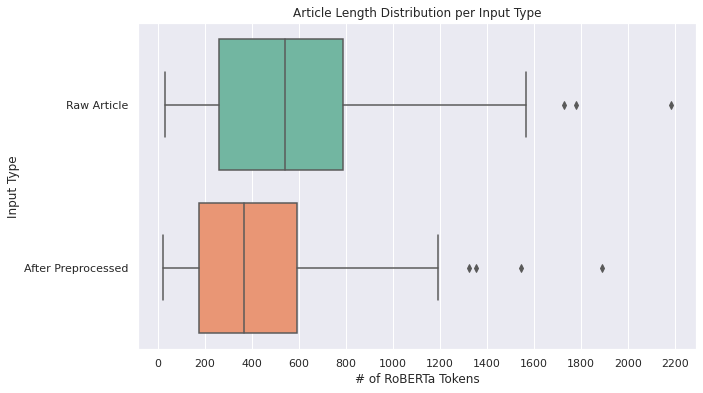

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the article length before and after cleaning
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(
    x='value',
    y='variable',
    data=pd.melt(pd.DataFrame({'Raw Article': RoBERTa_token_ct_before, 
                               'After Preprocessed': RoBERTa_token_ct_after})),
    orient="h",
    palette="Set2",
    ax=ax)

ax.set(xlabel='# of RoBERTa Tokens', ylabel='Input Type', title='Article Length Distribution per Input Type')
ax.set_xticks(range(0,2400, 200))
plt.show();

In [16]:
import scipy
print('Before:')
print(scipy.stats.describe(RoBERTa_token_ct_before))
print('median=', np.median(RoBERTa_token_ct_before))
print('\n')
print('After:')
print(scipy.stats.describe(RoBERTa_token_ct_after))
print('median=', np.median(RoBERTa_token_ct_after))

Before:
DescribeResult(nobs=140, minmax=(30, 2183), mean=578.1571428571428, variance=171386.8816032888, skewness=0.9169236199594548, kurtosis=1.0389494888940138)
median= 542.5


After:
DescribeResult(nobs=140, minmax=(24, 1892), mean=441.2142857142857, variance=119767.40698869475, skewness=1.1921650166442008, kurtosis=1.86757744368271)
median= 365.5


In [17]:
# See how many article can fit 512 input length without truncation
print('Before:')
percent_before = scipy.stats.percentileofscore(RoBERTa_token_ct_before, 512)
print(f'{percent_before/100:2.2%}', end='\n\n')

print('After:')
percent_after = scipy.stats.percentileofscore(RoBERTa_token_ct_after, 512)
print(f'{percent_after/100:2.2%}', end='\n\n')


print('Increment:')
print(f'{(percent_after-percent_before):.4}', end='\n\n')

print('Average Token loss (for documents longer than 512 tokens)')
avg_loss = np.mean([(i-512)/i for i in RoBERTa_token_ct_after if i > 512])
print(f'{avg_loss:2.2%}')

Before:
47.86%

After:
63.57%

Increment:
15.71

Average Token loss (for documents longer than 512 tokens)
29.99%


## Test RoBERTa-base Runtime
First, create the labels for the data

In [18]:
import tensorflow as tf

In [19]:
label_to_index = dict((name, index) for index, name in enumerate(list(data_df.country.unique())))
data_df['label'] = data_df['country'].map(lambda x: label_to_index[x])
data_df

,content,country,publisher,content_cleaned,label
0,Anatara Lifesciences Ltd (ASX:ANR) Human Healt...,Australia,ABN Newswire,(ASX : ANR) Human Health Update Anatara Lifesc...,0
1,Cyprium Metals Ltd (ASX:CYM) Diamond Drilling ...,Australia,ABN Newswire,(ASX : CYM) Diamond Drilling Commenced at Nana...,0
2,Ellis Martin Report: Skyharbour Resources (CVE...,Australia,ABN Newswire,Report : (: SYH) Expands High Grade Maverick E...,0
3,Betmakers Technology Group Ltd (ASX:BET) Sport...,Australia,ABN Newswire,(ASX : BET) Limited (ASX : BET) (FRA : T07) no...,0
4,NOVONIX Ltd (ASX:NVX) Benchmark Week 2020 Pres...,Australia,ABN Newswire,(ASX :) Benchmark Week 2020 Presentation (ASX ...,0
...,...,...,...,...,...
135,Towards a gender-equal world: a mission for al...,South Africa,Mail & Guardian,Towards gender - equal world : mission for all...,6
136,Cryptic crossword 261 - 4 December\nThe post C...,South Africa,Mail & Guardian,Cryptic crossword 261 - 4 December The post Cr...,6
137,Yet another treaty aims to protect African wom...,South Africa,Mail & Guardian,Yet another treaty aims to protect African wom...,6
138,Pivot your small business to online\nThis Mail...,South Africa,Mail & Guardian,Pivot your small business to online This Mail ...,6


In [20]:
MAX_LEN=128
NUM_CLASS=len(data_df.country.unique())

# Create Batch Tokenizer function
def regular_encode(texts, tokenizer, maxlen=MAX_LEN):
    """
    Function to encode the word
    """
    # encode the word to vector of integer
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_mask=True, 
        return_token_type_ids=False,
        padding='longest',
        truncation=True,
        max_length=maxlen)
    
    return np.array(enc_di['input_ids']), np.array(enc_di['attention_mask'])

# Get x and y inputs
x_ids, x_mask = regular_encode(data_df.content_cleaned.to_list(), tokenizer, maxlen=MAX_LEN)
y_train = data_df.label.values

In [21]:
# Create Batch Tokenizer function
from transformers import RobertaConfig, TFAutoModelForSequenceClassification 
import tensorflow as tf

config = RobertaConfig.from_pretrained(
    BERT_VERSION,
    num_labels=NUM_CLASS,
    dropout=0.1,
    attention_dropout=0.1,
    output_hidden_states=False,
    output_attentions=False
)

bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    BERT_VERSION, 
    trainable=True, 
    config=config)


bert_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)])

bert_model.summary()

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595975    
Total params: 124,651,015
Trainable params: 124,651,015
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Run a test epoch to make sure everything is set-up correctly
history = bert_model.fit(x=[x_ids, x_mask], y=y_train, epochs=1, validation_split=0.1)

4/4 [==============================] - 32s 3s/step - loss: 1.9557 - accuracy: 0.1270 - val_loss: 2.1315 - val_accuracy: 0.0000e+00


In [23]:
import time

time_history = []
score_history = []

# Take Log-2 Step
for sample_size in np.logspace(1, 8, num=7,base=2,endpoint=False, dtype='int'):
  print(f'Measuring time for {sample_size} samples')
  sample_set = data_df.sample(sample_size)
  sample_x_ids = sample_set.content
  sample_y = sample_set.label.values
  sample_x_ids, sample_x_mask = regular_encode(sample_set.content_cleaned.to_list(), tokenizer, maxlen=MAX_LEN)
  
  sample_time = []
  for trial in range(5):
    # redefine model everytime
    bert_model = TFAutoModelForSequenceClassification.from_pretrained(
        BERT_VERSION, 
        trainable=True, 
        config=config)
    bert_model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)])
    
    # Start Timing Section----------------
    start_time = time.time()
    history = bert_model.fit([sample_x_ids, sample_x_mask], sample_y, epochs=20, verbose=0, validation_split=0.1)
    end_time = time.time()
    # End Timing Section----------------

    # record time and maximum validation score
    score_history.append(np.max(history.history['val_accuracy']))
    sample_time.append(end_time-start_time)
  # record avg time
  time_history.append(np.mean(sample_time))

Measuring time for 2 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 4 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 8 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 16 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 32 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 64 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

Measuring time for 128 samples


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this mod

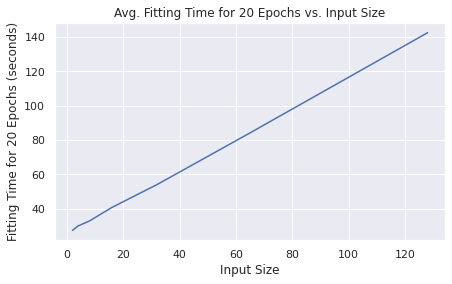

In [24]:
# Plot Time
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(7,4))

sns.lineplot(x=np.logspace(1, 8, num=7,base=2,endpoint=False, dtype='int'),
             y=time_history)
ax.set(xlabel='Input Size', ylabel='Fitting Time for 20 Epochs (seconds)', title='Avg. Fitting Time for 20 Epochs vs. Input Size')
plt.show()

In [25]:
# View Scores
np.array(score_history).reshape(5, -1)

array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        ],
       [1.        , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       ],
       [0.25      , 0.5       , 0.25      , 0.5       , 0.71428573,
        0.71428573, 0.71428573],
       [0.85714287, 0.85714287, 0.84615386, 0.92307693, 0.84615386,
        0.84615386, 0.92307693]])

In [26]:
# View mean Score of last set of trials
np.mean(np.array(score_history).reshape(5, -1)[-1])

0.8712715932301113